## Imports

In [1]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [2]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
DATA_DIR = '../input/deepglobe-road-extraction-dataset'

metadata_df = pd.read_csv(os.path.join(DATA_DIR, 'metadata.csv'))
metadata_df = metadata_df[metadata_df['split']=='train']
metadata_df = metadata_df[['image_id', 'sat_image_path', 'mask_path']]
metadata_df['sat_image_path'] = metadata_df['sat_image_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
metadata_df['mask_path'] = metadata_df['mask_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
# Shuffle DataFrame
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)

# train-test split
valid_df = metadata_df.sample(frac=0.1, random_state=42)
train_df = metadata_df.drop(valid_df.index)
len(train_df), len(valid_df)

(5603, 623)

In [4]:
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['road', 'background']
Class RGB values:  [[255, 255, 255], [0, 0, 0]]


In [5]:
select_classes = ['background', 'road']
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

## Utilities

In [6]:
# helper function for data visualization
def visualize(**images):
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]
    return x

## Dataset

In [7]:
class RoadsDataset(torch.utils.data.Dataset):
    def __init__(
            self, 
            df,
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.image_paths = df['sat_image_path'].tolist()
        self.mask_paths = df['mask_path'].tolist()
        
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        return image, mask
        
    def __len__(self):
        return len(self.image_paths)

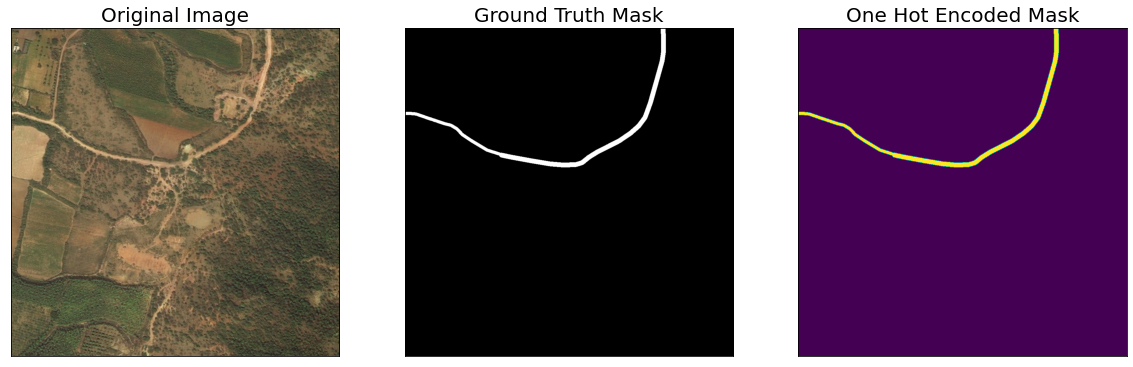

In [8]:
dataset = RoadsDataset(train_df, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[4]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [9]:
def get_training_augmentation():
    train_transform = [
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5),
    ]
    return album.Compose(train_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

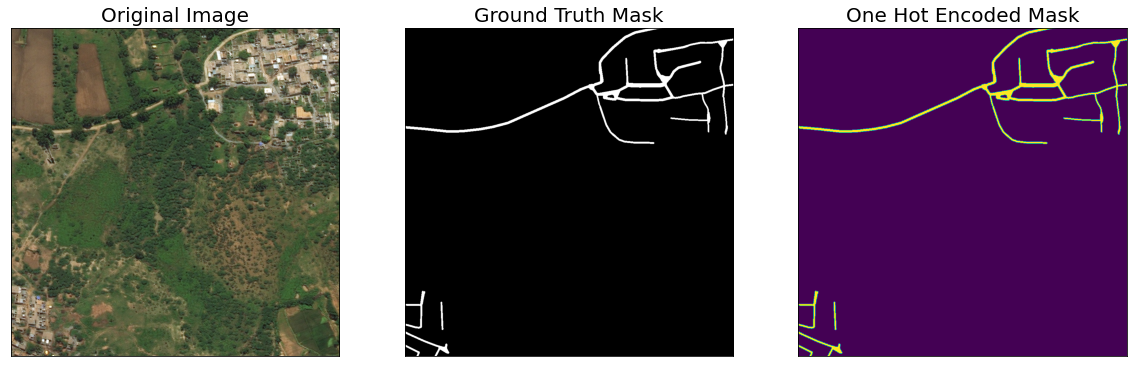

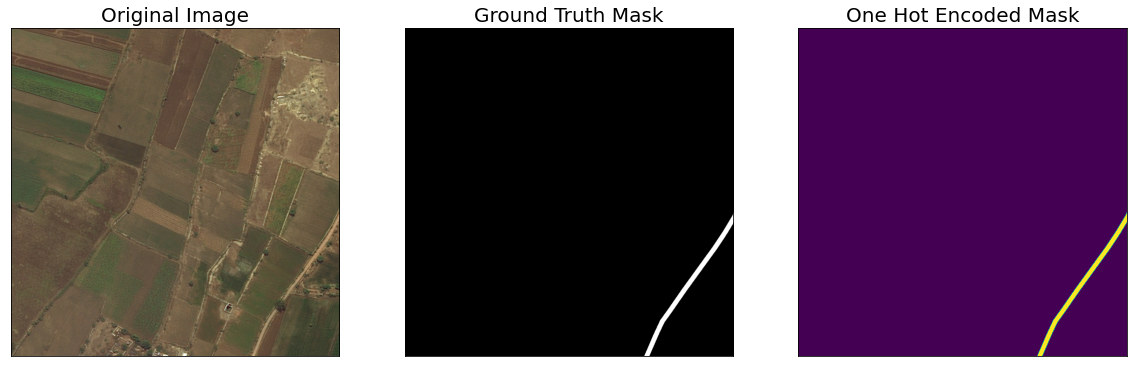

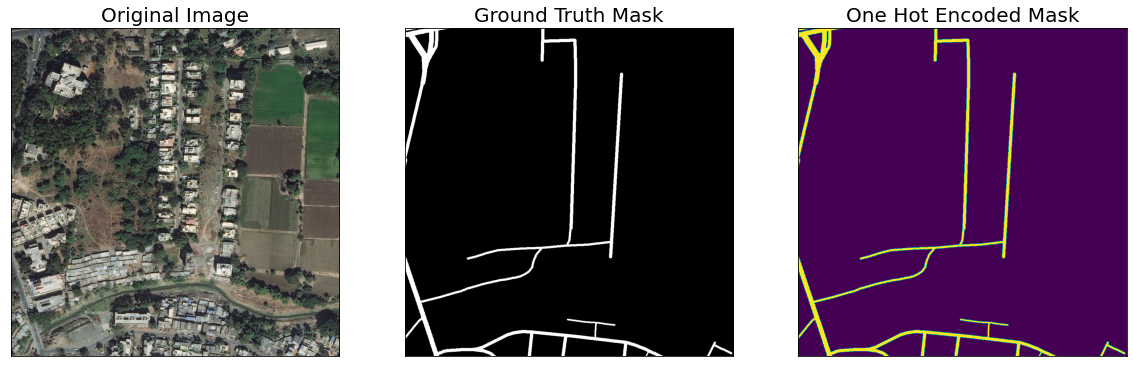

In [10]:
augmented_dataset = RoadsDataset(
    train_df, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on image/mask pairs
for idx in range(3):
    image, mask = augmented_dataset[idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

## Model

In [11]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid'

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [12]:
# Get train and val dataset instances
train_dataset = RoadsDataset(
    train_df, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = RoadsDataset(
    valid_df, 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=4)

## Hyperparams

In [13]:
TRAINING = False  # set False for only prediction
EPOCHS = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.5),]
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00008),
])
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint
if os.path.exists('../input/road-extraction-from-satellite-images-deeplabv3/best_model.pth'):
    model = torch.load('../input/road-extraction-from-satellite-images-deeplabv3/best_model.pth', map_location=DEVICE)
    print('Loaded pre-trained model!')

Loaded pre-trained model!


In [14]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

## Training

In [15]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


## Prediction on Test Data

In [16]:
# load best saved model checkpoint from the current run
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location=DEVICE)
    print('Loaded model from current run.')

# load best saved model checkpoint from previous commit (if present)
elif os.path.exists('../input/road-extraction-from-satellite-images-deeplabv3/best_model.pth'):
    best_model = torch.load('../input/road-extraction-from-satellite-images-deeplabv3/best_model.pth', map_location=DEVICE)
    print('Loaded model from a previous commit.')

Loaded model from a previous commit.


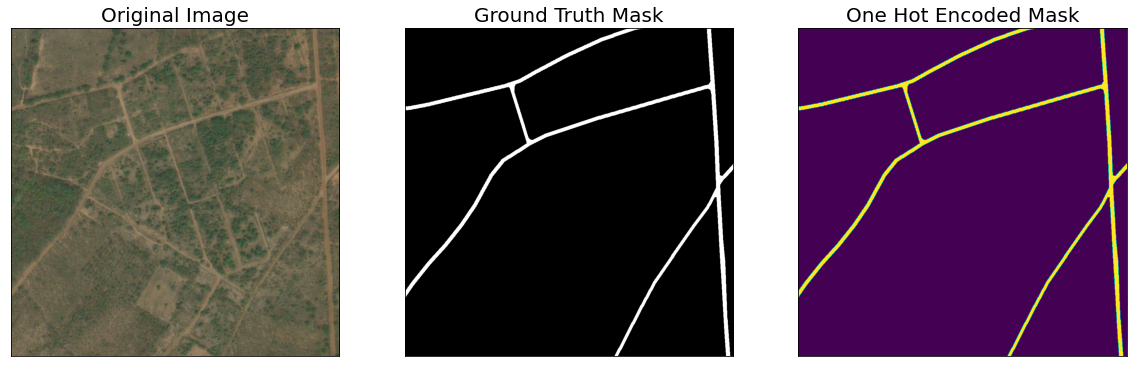

In [17]:
# create test dataloader (with preprocessing operation: to_tensor(...))
test_dataset = RoadsDataset(
    valid_df, 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing augmentations & transformations)
test_dataset_vis = RoadsDataset(
    valid_df,
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)


In [18]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

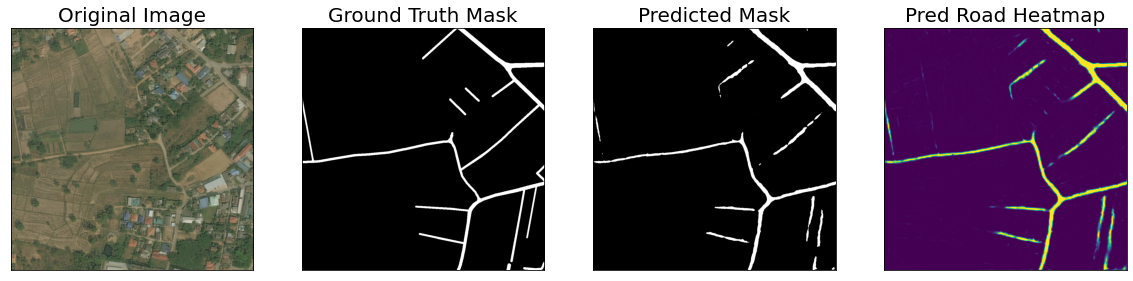

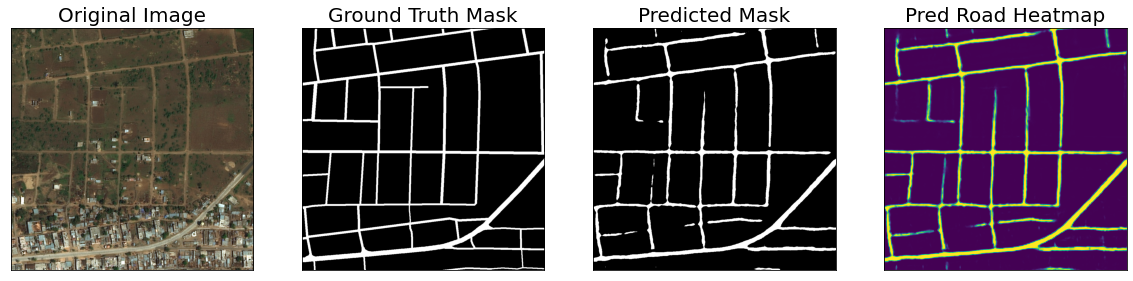

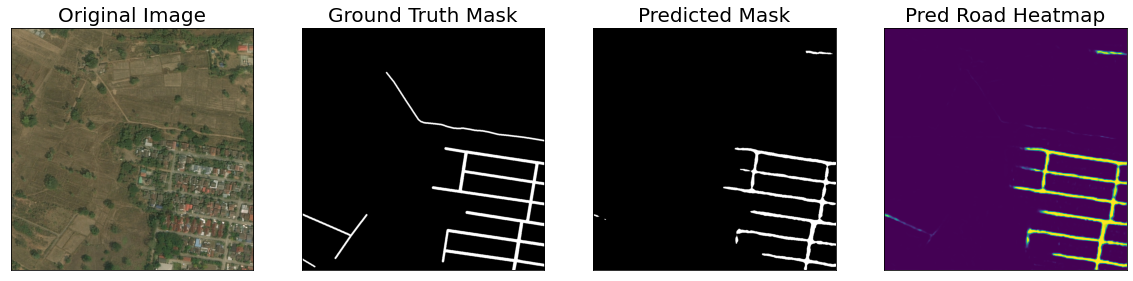

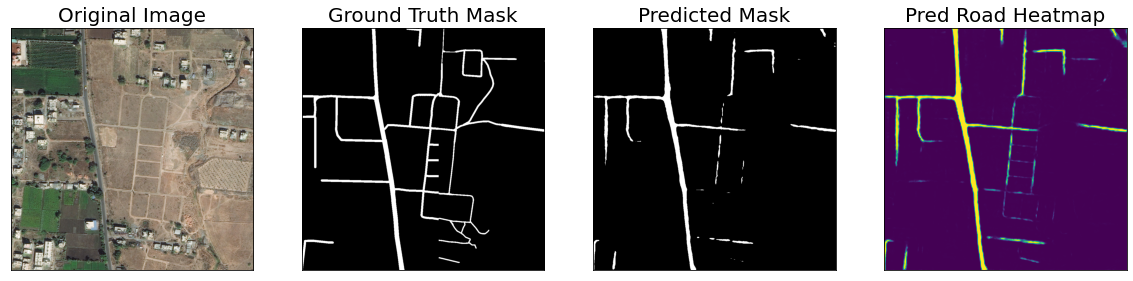

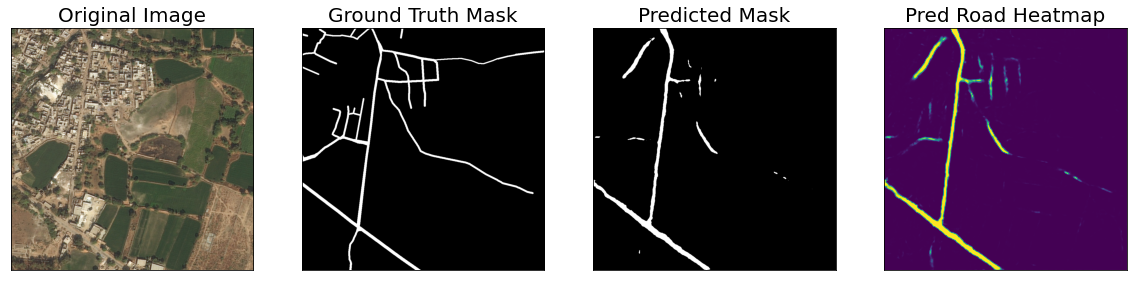

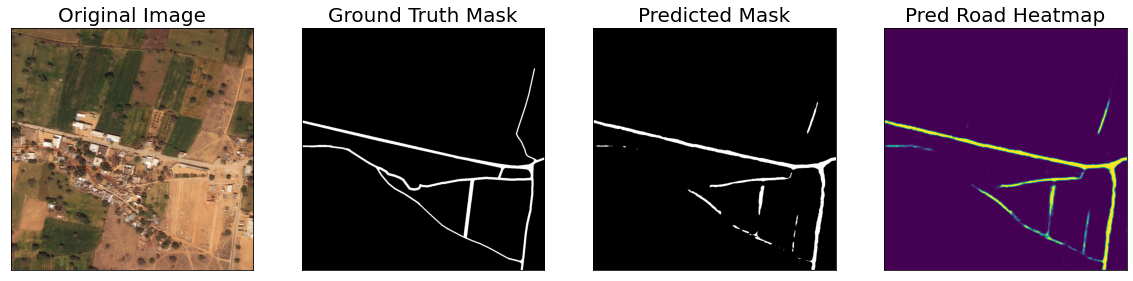

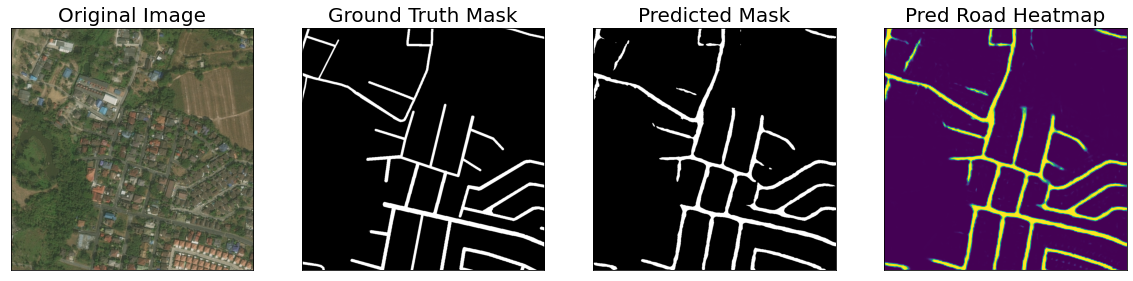

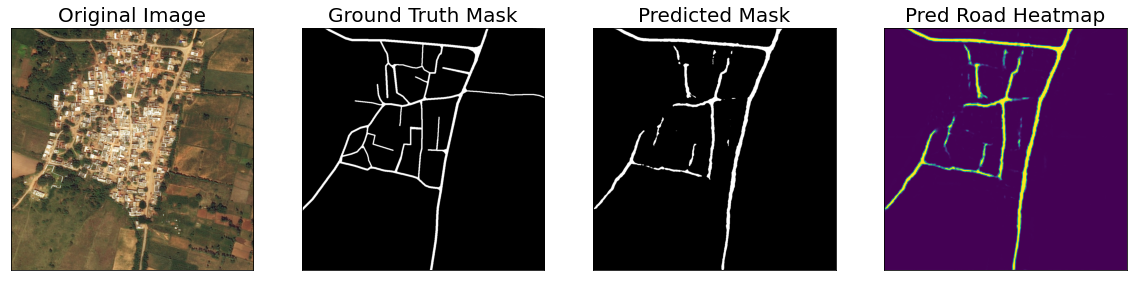

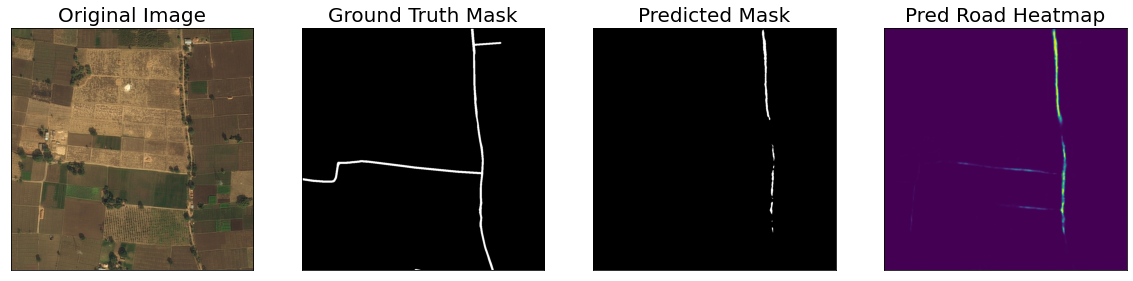

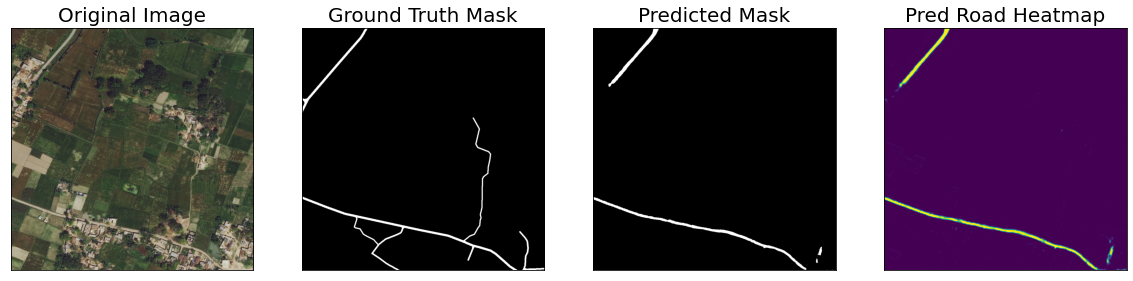

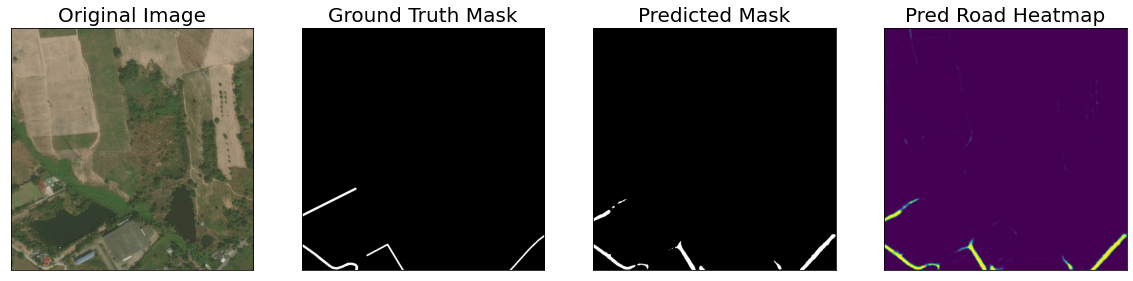

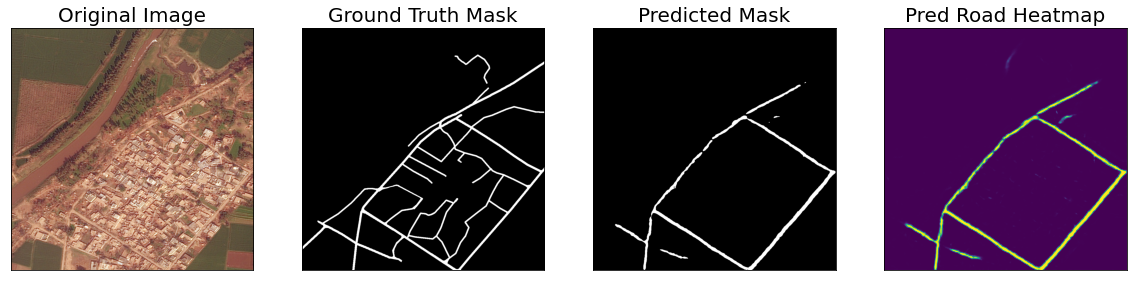

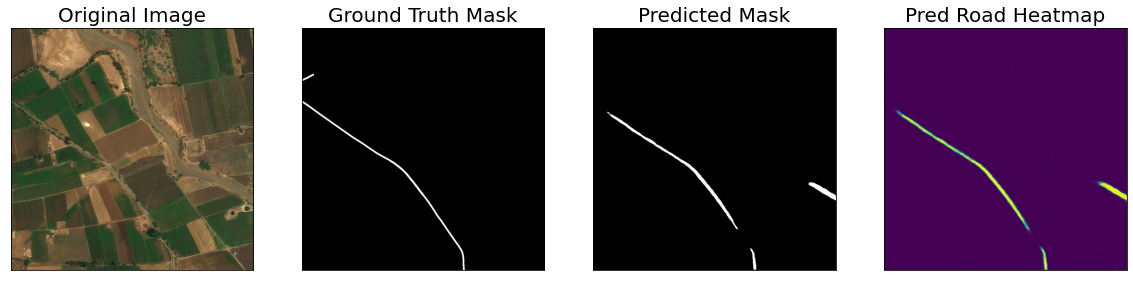

In [19]:
for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to foreground
    pred_road_heatmap = pred_mask[:,:,select_classes.index('road')]
    pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values)
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    if(idx%50 is 0):
        visualize(
            original_image = image_vis,
            ground_truth_mask = gt_mask,
            predicted_mask = pred_mask,
            pred_road_heatmap = pred_road_heatmap
        )

### Model Evaluation on Test Dataset

In [20]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 623/623 [02:05<00:00,  4.96it/s, dice_loss - 0.0315, iou_score - 0.9489]
Evaluation on Test Data: 
Mean IoU Score: 0.9489
Mean Dice Loss: 0.0315


### Plot Dice Loss & IoU Metric for Train vs. Val

In [21]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

NameError: name 'train_logs_list' is not defined

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()

## Performance on custom data

In [ ]:
import cv2
image = cv2.imread('../input/test-satellite-to-road/Image1.png')
image= cv2.resize(image,(1024,1024))
image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# preprocessing
img= preprocessing_fn(image)
x_tensor  = to_tensor(img)
x_tensor = torch.from_numpy(x_tensor).to(DEVICE).unsqueeze(0)
pred_mask = best_model(x_tensor)
pred_mask = pred_mask.detach().squeeze().cpu().numpy()
pred_mask = np.transpose(pred_mask,(1,2,0))
pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)
# show prediction
"""plt.figure()
plt.imshow(image)
plt.figure()
plt.imshow(pred_mask)"""
visualize(
    original_image = image,
    mask = pred_mask,
)

In [ ]:
img = cv2.imread('../input/test-satellite-to-road/Image3.png')
image= cv2.resize(img,(2048,1024))
#image = cv2.copyMakeBorder(img, 0, 10, 0, 10, cv2.BORDER_CONSTANT, None, value = 0)
image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
crop1 = image[0:1024, 0:1024]
crop2 = image[0:1024, 1024:2048]
crop1 = preprocessing_fn(crop1)
crop2 = preprocessing_fn(crop2)

x1_tensor  = to_tensor(crop1)
x1_tensor = torch.from_numpy(x1_tensor).to(DEVICE).unsqueeze(0)
pred_mask1 = best_model(x1_tensor)
pred_mask1 = pred_mask1.detach().squeeze().cpu().numpy()
pred_mask1 = np.transpose(pred_mask1,(1,2,0))
pred_mask1 = colour_code_segmentation(reverse_one_hot(pred_mask1), select_class_rgb_values)

x2_tensor  = to_tensor(crop2)
x2_tensor = torch.from_numpy(x2_tensor).to(DEVICE).unsqueeze(0)
pred_mask2 = best_model(x2_tensor)
pred_mask2 = pred_mask2.detach().squeeze().cpu().numpy()
pred_mask2 = np.transpose(pred_mask2,(1,2,0))
pred_mask2 = colour_code_segmentation(reverse_one_hot(pred_mask2), select_class_rgb_values)

final = cv2.hconcat([pred_mask1, pred_mask2])

plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.imshow(image)
plt.subplot(2,1,2)
plt.imshow(final)
plt.show()

In [ ]:
size=img.shape[:2]
size = size[::-1]
print(size)
final = final.astype('float32')
mask= cv2.resize(final,size)
#plt.figure(figsize=(20,10))
#plt.imshow(mask)
print(mask.shape)
cv2.imwrite("image6_mask.png", mask)

In [ ]:
print(img.shape)
print(img.shape)